In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)

## Varying the Exposure

In [4]:
savefig = True
picformat = 'svg'
true_energy = dataset_load.exposure.geom.axes[0].center.value

e_reco = 0.1
print(e_reco)


0.1


In [5]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_asimov_N = sys_d_cor.create_dataset_N()
dataset_asimov = sys_d_cor.create_dataset()
dataset_standard = sys_d_cor.create_dataset()


with dataset_asimov_N.models.parameters.restore_status(): 
    dataset_asimov_N.models.parameters['e_reco'].value = e_reco
    dataset_asimov.counts = dataset_asimov_N.npred()
    dataset_asimov_N.counts = dataset_asimov_N.npred()


sigma_e = 0.1

penalising_covmatrix = [[1/sigma_e**2]]
penalising_invcovmatrix =  penalising_covmatrix
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
#dataset_asimov.models.parameters['e_reco'].value = e_reco



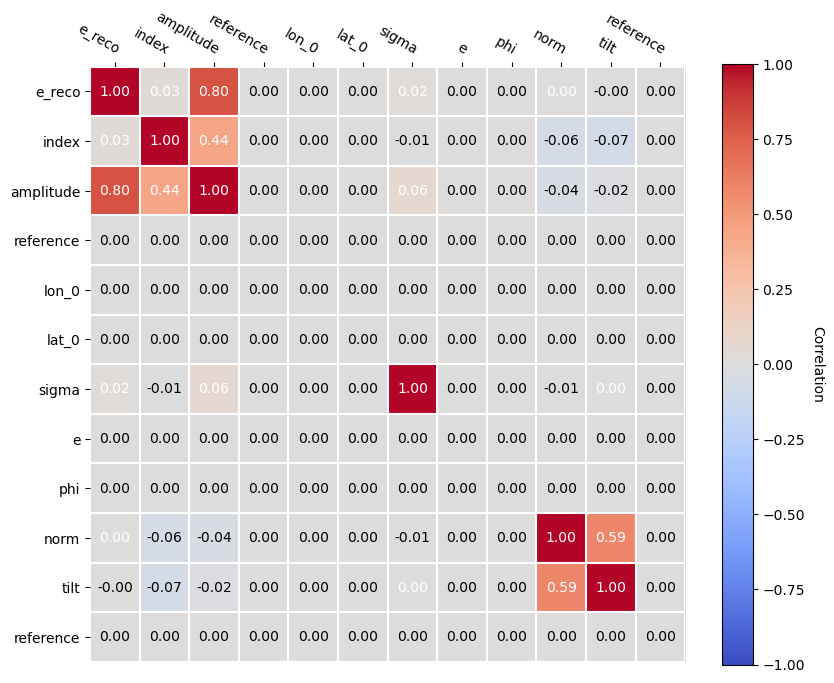

In [9]:

dataset_asimov_N.models[0].parameters['e_reco'].frozen = False

fit_cor = Fit(store_trace=False)

result_cor = fit_cor.run([dataset_asimov])    
result_cor = fit_cor.run([dataset_asimov_N]) 


dataset_asimov_N.models.covariance = fit_cor.covariance(dataset_asimov_N).matrix
dataset_asimov_N.models.covariance.plot_correlation()

dataset_asimov_N.models[0].spectral_model.model.covariance = dataset_asimov_N.models.covariance.get_subcovariance(dataset_asimov_N.models[0].spectral_model.model.parameters)
dataset_asimov_N.models[0].spectral_model.model.covariance = dataset_asimov_N.models.covariance.get_subcovariance(dataset_asimov_N.models[0].spectral_model.model.parameters)

dataset_asimov_N.models[0].parameters['e_reco'].frozen = True


In [10]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

index
amplitude
index
amplitude
index
amplitude
index
amplitude


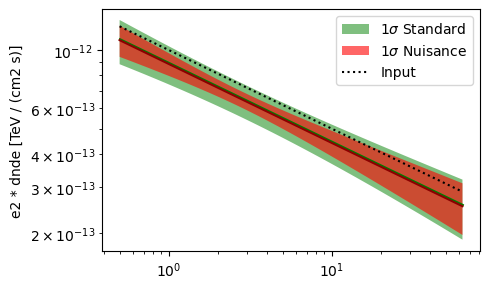

In [14]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3))

dataset_asimov_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "green", alpha = 0.5) 
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    
   
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "darkred")    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "red", alpha = 0.6)



dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [15]:
compute_fluxpoints = 1
if compute_fluxpoints:
    energy_edges = dataset_asimov.geoms['geom'].axes[0].edges
    esti  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = False)
    fluxpoints_asimov = esti.run([dataset_asimov])
    fluxpoints_asimov.write("data/6_fluxpoints_asimov.fits", overwrite = True)
else:
    fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits", )
    

In [16]:
if compute_fluxpoints:

    esti_N  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = True)
    ## modify the covariance matrix, because only one nuisance parameter here
    with dataset_asimov_N.models.restore_status():
        dataset_asimov_N.models.parameters.freeze_all()
        dataset_asimov_N.models.parameters['e_reco'].frozen = False
        fluxpoints_asimov_N = esti_N.run(dataset_asimov_N)

    fluxpoints_asimov_N.write("data/6_fluxpoints_asimov_N.fits", overwrite = True)
else:
    fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits",)
    

In [17]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

index
amplitude
index
amplitude


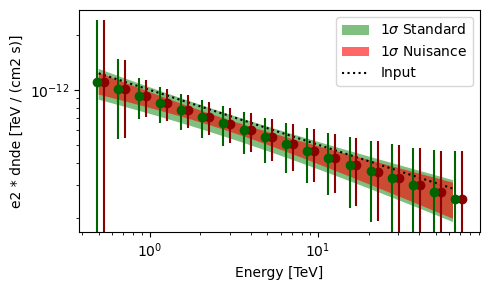

In [18]:
fig, axs = plt.subplots(1,1, figsize = (5,3))

dataset_asimov_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "green", alpha = 0.5) 
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/6_fluxpoints_asimov."+ picformat)
